We will benchmark the elastic $(p,p)$, $(n,n)$ and quasi-elastic $(p,n)$ calculations comparing `JITR` to `CHEX`.

In [83]:
import pickle
from pathlib import Path

import chexpy
import numpy as np
import pandas as pd
import rose
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import jitr

In [2]:
print(rose.__version__)

1.1.3.dev6+g772a848


In [3]:
from rose.koning_delaroche import KDGlobal, Projectile

n = Projectile.neutron
p = Projectile.proton

# initial and final systems
# Core p + Ca48
Ca48 = (48, 20)

# n + IAS
Sc48 = (48, 21)

# lab bombarding energy
E_lab = 25  # MeV

# excitation energy to isobaric analog state
E_IAS = 6.67  # MeV

# approximation of -Q - the Coulomb displacement energy
CDE = 1.33 * (Ca48[1] + Sc48[1]) * 0.5 / Ca48[0] ** (1.0 / 3.0)

# excitation energy to isobaric analog state
Q_IAS = (
    rose.utility.get_AME_binding_energy(*Sc48)
    - rose.utility.get_AME_binding_energy(*Ca48)
    - E_IAS
)
print(f"Q = {Q_IAS}, CDE = {CDE}")

# set up global optical model potentials w/ default KD params
omps = {
    n: rose.koning_delaroche.KDGlobal(n),
    p: rose.koning_delaroche.KDGlobal(p),
}

Q = -7.173131200000098, CDE = 7.502253870092668


In [4]:
xsn = pd.read_csv(
    "./chex_benchmark_results/ca48_25MeV_pn/OutNucleonElasticCS.txt",
    names=["theta", "dxs", "err"],
    sep="\s+",
)

In [5]:
xsp = pd.read_csv(
    "./chex_benchmark_results/ca48_25MeV_pn/InNucleonRatioToRuth.txt",
    names=["theta", "dxs", "err"],
    sep="\s+",
)

In [6]:
# set up meshes for visualization
a = 30
angles = np.array(xsn["theta"], dtype=np.float64) * np.pi / 180

In [7]:
interactions = {}
params = {}

In [8]:
# set up p + Ca48 system
# kinematics for p + Ca48 system
mu_p, E_com_p, k_p, eta_p = rose.utility.kinematics(
    target=Ca48, projectile=(1, 1), E_lab=E_lab
)

# get default OMP params for p + Ca48 system
R_C, parameters = omps[p].get_params(*Ca48, mu_p, E_lab, k_p)

params[p] = (R_C, parameters)

# set up interaction space for p + Ca48 system
interactions[p] = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=mu_p,
    energy=E_com_p,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=1,
    Z_2=Ca48[1],
    R_C=R_C,
    l_max=50,
)

In [9]:
# set up n + Sc48 system
# kinematics for n + Sc48 system
E_com_n = E_com_p + Q_IAS
mu_n, E_lab_n, k_n, eta_n = rose.utility.kinematics(
    target=Sc48, projectile=(1, 0), E_com=E_com_n
)

# get default OMP params for n + Sc48 system
_, parameters = omps[n].get_params(*Sc48, mu_n, E_lab_n, k_n)
params[n] = (R_C, parameters)

# set up interaction space for n + Sc48 system
interactions[n] = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=mu_n,
    energy=E_com_n,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=0,
    Z_2=Sc48[1],
    l_max=50,
)

In [10]:
s_0_p = a * k_p
s_0_n = a * k_n
min_s = 1e-1
s_mesh_p = np.linspace(min_s, s_0_p, 1000)
domain_p = [min_s, s_0_p]
s_mesh_n = np.linspace(min_s, s_0_n, 1000)
domain_n = [min_s, s_0_n]

In [11]:
solver = jitr.RMatrixSolver(50)

In [12]:
# set up solvers
N = 100
solvers = {}

solvers[n] = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions[n],
    base_solver=rose.LagrangeRmatrix(
        interactions[n].interactions[0][0],
        s_0_n,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_n,
)

solvers[p] = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions[p],
    base_solver=rose.LagrangeRmatrix(
        interactions[p].interactions[0][0],
        s_0_p,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_p,
)

Let's compare the value of the isovector component of the optical potential the `JITR` solver and the original `CHEX` solver, for a single partial wave.

In [13]:
params[p][1]

array([50.96318785,  4.33328708,  0.6706624 ,  2.29860499,  4.33328708,
        0.6706624 ,  8.13772168,  4.66926318,  0.543684  ,  5.32128688,
        3.6610295 ,  0.59      , -0.12462904,  3.6610295 ,  0.59      ])

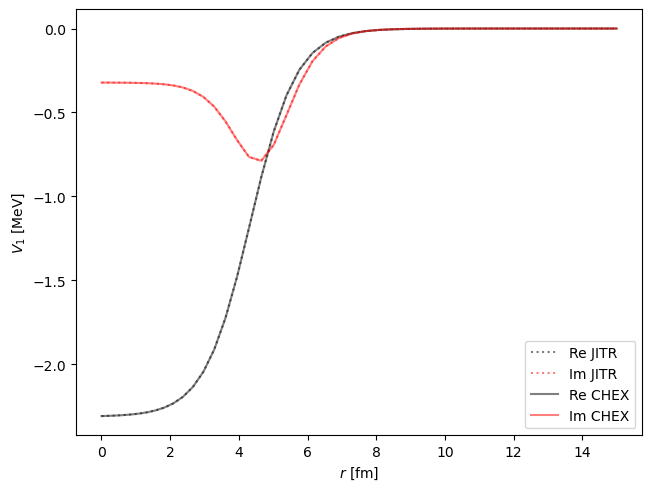

In [14]:
import pandas as pd

chex_v1 = pd.read_csv(
    "./chex_benchmark_results/ca48_25MeV_pn/KD_pot.txt",
    names=["r", "V", "W"],
    sep="\s+",
)

# CHEX uses Ecm to evaluate V1, not Elab. Elab is used for distorted waves
# CHEX also includes the full Coulomb potential in V1

# to do apples to apples, lets get new params with Ecm and calculate V1 in the same way as CHEX
_, alphan = omps[n].get_params(*Sc48, mu_n, E_com_n, k_n)
RC, alphap = omps[p].get_params(*Ca48, mu_p, E_com_p, k_p)


def jitr_v1(r, li, ji, alphan, alphap, chex_way=True):
    A, Z = Ca48
    N = A - Z
    vn = interactions[n].interactions[li][ji].v_r(r, alphan) + interactions[
        n
    ].interactions[li][ji].spin_orbit_term.spin_orbit_potential(r, alphan)
    vp = interactions[p].interactions[li][ji].v_r(r, alphap) + interactions[
        p
    ].interactions[li][ji].spin_orbit_term.spin_orbit_potential(r, alphap)
    if chex_way:
        v1 = -(vn - vp) * np.sqrt(np.fabs(N - Z)) / (N - Z - 1)  # the CHEX way
    else:
        v1 = -(vn - vp) / np.sqrt(np.abs(N - Z))  # the correct way
    return v1


r = np.array(chex_v1["r"])
jitrv1 = jitr_v1(r, 0, 0, alphan, alphap, chex_way=True)
plt.plot(r, jitrv1.real, ":k", label="Re JITR", alpha=0.5)
plt.plot(r, jitrv1.imag, ":r", label="Im JITR", alpha=0.5)

plt.plot(chex_v1["r"], chex_v1["V"], "k", label="Re CHEX", alpha=0.5)
plt.plot(chex_v1["r"], chex_v1["W"], "r", label="Im CHEX", alpha=0.5)

plt.legend()
plt.tight_layout()
plt.xlabel(r"$r$ [fm]")
plt.ylabel(r"$V_1$ [MeV]")
plt.show()

Let's compare phase shifts and partial waves between the `JITR` solver and the original `CHEX` solver, for a single partial wave.

Let's compare the elastic cross sections for the entrance and exit channels between the `JITR` solver and the original `CHEX` solver, for a single partial wave.

First, for comparison, let's duplicate the same solvers and interactions, but using the same reduced mass as CHEX, which is just calculated like $A/(A+1)m_n$. This will tell us about how important our relativistic correction is.

In [15]:
interactions_kip = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=912.48391836734697,
    energy=E_com_p,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=1,
    Z_2=Ca48[1],
    R_C=R_C,
    l_max=50,
)
solvers_kip = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions_kip,
    base_solver=rose.LagrangeRmatrix(
        interactions_kip.interactions[0][0],
        s_0_p,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_p,
)
dxs_kip = solvers_kip.exact_dsdo(params[p][1])

/home/beyerk/Projects/jitr/src/jitr/rmatrix.py:46: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 1, 'C', False, aligned=True), Array(complex128, 2, 'A', False, aligned=True))
  R, Ainv = rmatrix_with_inverse(A, b, nchannels, nbasis, a)


In [16]:
# for the proton case, our original solver with good kineamatics
dxs = solvers[p].exact_dsdo(params[p][1])

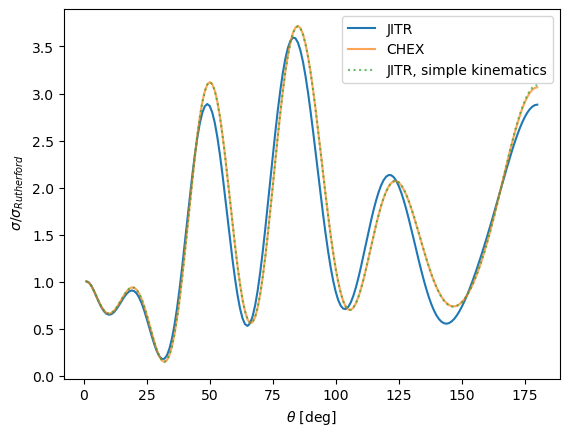

In [17]:
plt.plot(angles * 180 / np.pi, dxs, label="JITR")
plt.plot(
    xsp["theta"],
    xsp["dxs"],
    label="CHEX",
    alpha=0.7,
)
plt.plot(angles * 180 / np.pi, dxs_kip, ":", alpha=0.7, label="JITR, simple kinematics")

plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r" $\sigma / \sigma_{Rutherford}$")
plt.legend()

In [18]:
# %%timeit
# now for the neutron case
dxs = solvers[n].exact_dsdo(params[n][1])

In [19]:
# use same kinematics as chex
interactions_chex_match_kin = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=912.48391836734697,
    energy=E_com_n,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=0,
    Z_2=Sc48[1],
    l_max=50,
)
solver_chex_match_kin = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions_chex_match_kin,
    base_solver=rose.LagrangeRmatrix(
        interactions_chex_match_kin.interactions[0][0],
        s_0_n,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_n,
)
dxs_kin = solver_chex_match_kin.exact_dsdo(params[n][1])

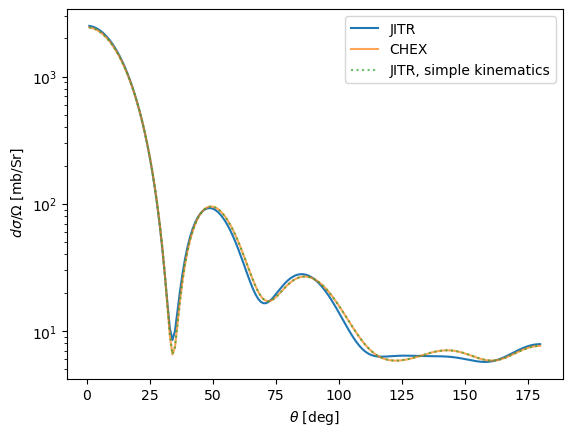

In [20]:
plt.semilogy(angles * 180 / np.pi, dxs, label="JITR")

plt.semilogy(xsn["theta"], xsn["dxs"], label="CHEX", alpha=0.7)
plt.semilogy(
    angles * 180 / np.pi, dxs_kin, ":", label="JITR, simple kinematics", alpha=0.7
)

plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r" $d \sigma / \Omega$ [mb/Sr]")
plt.legend()

We can see now that `JITR` is able to reproduce the differential elastic cross sections of `CHEX`, which means, asymptotically, the wavefunctions are the same up to an overall phase and normalization. For DWBA, we actually need to enforce a single, specific phase and normalization, namely

\begin{equation}
    u_l(r) \rightarrow \frac{i}{2} \left[ H_l^-(kr) - S_{jl} H^+_l(kr)  \right].
\end{equation}

This common convention is adopted by Thompson & Nunes, 2009, and is utilized in `CHEX` for the DWBA calculation.

#### read in CHEX wavefunctions for incoming and outgoing partial wave

In [151]:
# read in CHEX proton partial waves
from io import StringIO


def get_partial_wave(csv):
    return [float(x) for x in csv[0 : csv.find("\n")].strip().split()]


with open(
    "./chex_benchmark_results/ca48_25MeV_pn/InNucleonScatWFs.txt", "r"
) as uin_file:
    wfp = [
        (
            get_partial_wave(csv),
            pd.read_csv(
                StringIO(csv[csv.find("\n") :].split("&")[0]),
                sep="\s+",
                header=None,
                names=["r", "real", "imag"],
            ),
        )
        for csv in uin_file.read().split("#")[1:]
    ]

In [158]:
# read in CHEX neutron partial waves
from io import StringIO


def get_partial_wave(csv):
    return [float(x) for x in csv[0 : csv.find("\n")].strip().split()]


with open(
    "./chex_benchmark_results/ca48_25MeV_pn/OutNucleonScatWFs.txt", "r"
) as uin_file:
    wfn = [
        (
            get_partial_wave(csv),
            pd.read_csv(
                StringIO(csv[csv.find("\n") :].split("&")[0]),
                sep="\s+",
                header=None,
                names=["r", "real", "imag"],
            ),
        )
        for csv in uin_file.read().split("#")[1:]
    ]

In [159]:
from mpmath import coulombf, coulombg

0.0 0.5
0 0


Text(0.5, 0, '$r$ [fm]')

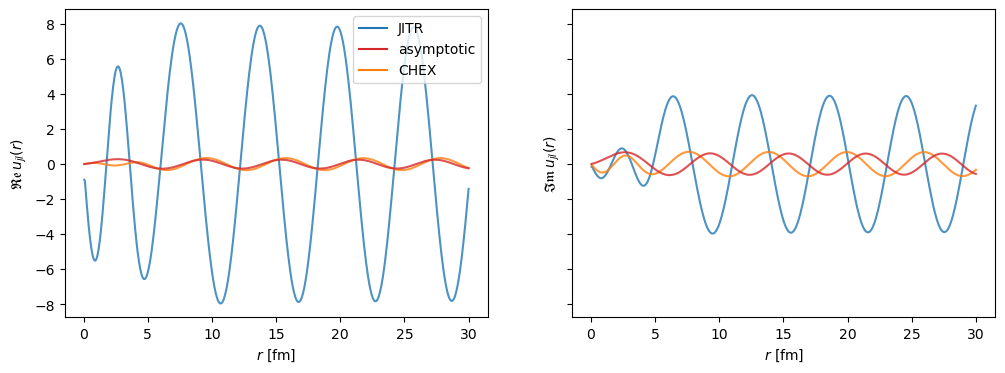

In [175]:
idx = 0
idx_l = (idx + 1) // 2
idx_j = (idx + 1) % 2 if idx > 0 else 0
(l, j) = d[idx][0]
print(l,j)
print(idx_l, idx_j)

r = wfp[idx][1]["r"].to_numpy(dtype=float)

F = np.array([coulombf(l, eta_p, s * k_p) for s in r], dtype=np.complex128)
G = np.array([coulombf(l, eta_p, s * k_p) for s in r], dtype=np.complex128)
Hp = G + 1j * F
Hm = G - 1j * F

Sl = solvers_kip.exact_smatrix_elements(params[p][1])[idx_l][idx_j]
u_asymptotic = 1j / 2 * (Hm - Sl * Hp)
u_chex = wfp[idx][1]["real"].to_numpy() + 1j * wfp[idx][1]["imag"].to_numpy()

# get JITR wavefunction
u_jitr_in = solvers_kip.exact_wave_functions(params[p][1])
u_jitr = np.interp(r, r_jitr, u_jitr_in[idx][idx_j])

#i_max = -10
#u_jitr *= np.mean(u_asymptotic[-10:] / u_jitr[-10:])

fig, (a1, a2) = plt.subplots( 1,2, sharey=True, figsize=(12,4))
a1.plot(r, u_jitr.real, "-", color="#1f77b4", alpha=0.8)
a2.plot(r, u_jitr.imag, "-", color="#1f77b4", alpha=0.8)

a1.plot( r, u_chex.real , "-", color="#ff7f0e", alpha=0.8)
a2.plot( r, u_chex.imag,  "-", color="#ff7f0e", alpha=0.8)

a1.plot(r, u_asymptotic.real, "-", color="#d62728", alpha=0.8)
a2.plot(r, u_asymptotic.imag, "-", color="#d62728", alpha=0.8)

a1.legend(
    handles=[
        Line2D([], [], color="#1f77b4", label="JITR"),
        Line2D([], [], color="#d62728", label="asymptotic"),
        Line2D([], [], color="#ff7f0e", label="CHEX"),

    ]
)

a1.set_ylabel(r"$\mathfrak{Re} \, u_{jl}(r)$")
a2.set_ylabel(r"$\mathfrak{Im} \, u_{jl}(r)$")
a1.set_xlabel(r"$r$ [fm]")
a2.set_xlabel(r"$r$ [fm]")

0.0 0.5
0 0


Text(0.5, 0, '$r$ [fm]')

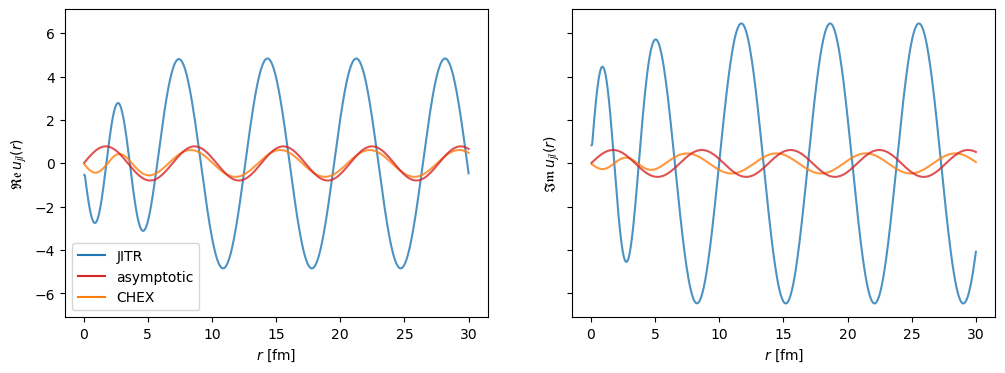

In [176]:
idx = 0
idx_l = (idx + 1) // 2
idx_j = (idx + 1) % 2 if idx > 0 else 0
(l, j) = d[idx][0]
print(l,j)
print(idx_l, idx_j)

r = wfn[idx][1]["r"].to_numpy(dtype=float)

F = np.array([coulombf(l, 0, s * k_n) for s in r], dtype=np.complex128)
G = np.array([coulombf(l, 0, s * k_n) for s in r], dtype=np.complex128)
Hp = G + 1j * F
Hm = G - 1j * F

Sl = solver_chex_match_kin.exact_smatrix_elements(params[n][1])[idx_l][idx_j]
u_asymptotic = 1j / 2 * (Hm - Sl * Hp)
u_chex = wfn[idx][1]["real"].to_numpy() + 1j * wfn[idx][1]["imag"].to_numpy()

# get JITR wavefunction
u_jitr_in = solver_chex_match_kin.exact_wave_functions(params[n][1])
u_jitr = np.interp(r, r_jitr, u_jitr_in[idx][idx_j])

#i_max = -10
#u_jitr *= np.mean(u_asymptotic[-10:] / u_jitr[-10:])

fig, (a1, a2) = plt.subplots( 1,2, sharey=True, figsize=(12,4))
a1.plot(r, u_jitr.real, "-", color="#1f77b4", alpha=0.8)
a2.plot(r, u_jitr.imag, "-", color="#1f77b4", alpha=0.8)

a1.plot( r, u_chex.real , "-", color="#ff7f0e", alpha=0.8)
a2.plot( r, u_chex.imag,  "-", color="#ff7f0e", alpha=0.8)

a1.plot(r, u_asymptotic.real, "-", color="#d62728", alpha=0.8)
a2.plot(r, u_asymptotic.imag, "-", color="#d62728", alpha=0.8)

a1.legend(
    handles=[
        Line2D([], [], color="#1f77b4", label="JITR"),
        Line2D([], [], color="#d62728", label="asymptotic"),
        Line2D([], [], color="#ff7f0e", label="CHEX"),

    ]
)

a1.set_ylabel(r"$\mathfrak{Re} \, u_{jl}(r)$")
a2.set_ylabel(r"$\mathfrak{Im} \, u_{jl}(r)$")
a1.set_xlabel(r"$r$ [fm]")
a2.set_xlabel(r"$r$ [fm]")